# Data Analytics I: Assignment 3

imports

In [1]:
import pandas as pd
import numpy as np

from itertools import combinations
import csv

## Data Preprocessing

### 1. Forming transactional dataset

In [2]:
df = pd.read_csv("../ml-latest-small/ratings.csv")

df_filtered = df[df["rating"] > 2]

user_movie_counts = df_filtered.groupby("userId").size()
valid_users = user_movie_counts[user_movie_counts > 10].index

df_valid_users = df_filtered[df_filtered["userId"].isin(valid_users)]

transactional_data = (
    df_valid_users.groupby("userId")["movieId"].apply(set).reset_index()
)

In [3]:
transactional_data.to_csv("transactional_data.csv", index=False)

### 2. Train-test split

In [4]:
def split_movies(movies):
    movies = np.array(list(movies))
    np.random.shuffle(movies)
    split_idx = int(len(movies) * 0.8)
    train_movies = movies[:split_idx]
    test_movies = movies[split_idx:]
    return set(train_movies), set(test_movies)

In [5]:
train_data = []
test_data = []

for index, row in transactional_data.iterrows():
    user_id = row['userId']
    movies = row['movieId']
    
    train_movies, test_movies = split_movies(movies)
    
    train_data.append({'userId': user_id, 'movieId': train_movies})
    
    if test_movies:
        test_data.append({'userId': user_id, 'movieId': test_movies})

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

In [6]:
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

## Association Rule Mining

### 1. Apriori Algorithm

In [7]:
def generate_candidates(Lk, k):
    """
    Generate candidate itemsets of size k+1 from frequent itemsets of size k.
    """
    candidates = set()
    Lk_list = list(Lk)
    
    for i in range(len(Lk_list)):
        for j in range(i + 1, len(Lk_list)):
            # Join step: create k+1 candidate itemset by combining two k-itemsets
            candidate = Lk_list[i].union(Lk_list[j])
            if len(candidate) == k + 1:
                candidates.add(candidate)
    
    return candidates


def prune_candidates(Ck, Lk, k):
    """
    Prune the candidate set Ck by removing itemsets where any (k-1)-subset is not in Lk.
    """
    
    pruned_candidates = set()
    for candidate in Ck:
        all_subsets_frequent = True
        for subset in combinations(candidate, k):
            if frozenset(subset) not in Lk:
                all_subsets_frequent = False
                break
        if all_subsets_frequent:
            pruned_candidates.add(candidate)

    return pruned_candidates


def get_frequent_itemsets(transactions, candidates, minsup):
    """
    Count the support of candidates and return the frequent itemsets.
    """

    candidate_counts = {candidate: 0 for candidate in candidates}
    
    # Count occurrences of each candidate in the transaction set
    for transaction in transactions:
        for candidate in candidates:
            if candidate.issubset(transaction):
                candidate_counts[candidate] += 1
    
    # Filter candidates by minimum support
    total_transactions = len(transactions)
    frequent_itemsets = {candidate for candidate, count in candidate_counts.items() if count / total_transactions >= minsup}
    
    return frequent_itemsets


In [8]:
def apriori(transactions, min_support):
    """
    Apriori algorithm to find frequent itemsets.
    transactions: list of transactions (each transaction is a set of items)
    min_support: minimum support threshold
    """
    # Step 1: Find frequent 1-itemsets
    item_support = {}
    for transaction in transactions:
        for item in transaction:
            if item not in item_support:
                item_support[item] = 0
            item_support[item] += 1

    total_transactions = len(transactions)
    L1 = {
        frozenset([item])
        for item, count in item_support.items()
        if count / total_transactions >= min_support
    }

    L = [L1]
    k = 1

    while L[k - 1]:
        # Step 2: Generate candidate itemsets of size k+1
        Ck = generate_candidates(L[k - 1], k)

        # Step 3: Prune candidate itemsets
        Ck = prune_candidates(Ck, L[k - 1], k)

        # Step 4: Get frequent itemsets from the candidate set
        Lk = get_frequent_itemsets(transactions, Ck, min_support)

        if Lk:
            L.append(Lk)
            k += 1
        else:
            break

    return set().union(*L) if L else set()

In [9]:
def calculate_support(itemset, transactions):
    """
    Calculate the support count of an itemset in the transactions.
    Returns the support as a fraction (support count / total_transactions).
    """
    total_transactions = len(transactions)
    count = sum(1 for transaction in transactions if itemset.issubset(transaction))
    return count / total_transactions  

In [10]:

def generate_rules(frequent_itemsets, transactions, min_conf):
    """
    Generate association rules from frequent itemsets where the antecedent X is a single item,
    and the consequent Y can be a set.
    """
    rules = []
    
    for itemset in frequent_itemsets:
        itemset_list = list(itemset)
        if len(itemset_list) > 1:
            for item in itemset_list:
                antecedent = frozenset([item])  # Antecedent X is a single item
                consequent = itemset - antecedent  # Consequent Y is the rest of the itemset
                if consequent:
                    support_itemset = calculate_support(itemset, transactions)
                    support_antecedent = calculate_support(antecedent, transactions)
                    
                    confidence = support_itemset / support_antecedent
                    
                    if confidence >= min_conf:
                        rule = (antecedent, consequent, confidence, support_itemset)
                        rules.append(rule)
    
    return rules


In [11]:
transactions = [set(movies) for movies in train_df['movieId']]

In [12]:
min_support = 0.05

frequent_itemsets = apriori(transactions, min_support)

print(f"Frequent Itemsets: {frequent_itemsets}")

Frequent Itemsets: {frozenset({1036, 1198}), frozenset({6874, 32587, 356}), frozenset({1193, 2571}), frozenset({5952, 7153, 260, 318}), frozenset({1210, 1258, 2959}), frozenset({1196, 260, 5989}), frozenset({4306, 780}), frozenset({588, 5349}), frozenset({377, 589, 110}), frozenset({8360, 1210}), frozenset({3948, 780}), frozenset({480, 2028, 110}), frozenset({4993, 3793, 5445}), frozenset({2858, 1732, 260}), frozenset({7361, 47}), frozenset({296, 2683}), frozenset({32, 357}), frozenset({2762, 4262}), frozenset({608, 260, 1196, 318}), frozenset({4993, 1206, 47}), frozenset({4226, 260, 1213}), frozenset({296, 5989, 2959, 47}), frozenset({296, 595, 318}), frozenset({2858, 2571, 260}), frozenset({7153, 4306}), frozenset({32, 1682, 1196}), frozenset({592, 356, 500, 364}), frozenset({296, 1, 589}), frozenset({1240, 1196, 1517}), frozenset({1136, 500}), frozenset({7153, 260, 2959}), frozenset({110, 588, 316}), frozenset({296, 904}), frozenset({593, 1089, 260, 296}), frozenset({296, 1617, 260}

In [13]:
min_conf = 0.7

rules = generate_rules(frequent_itemsets, transactions, min_conf)

for rule in rules:
    antecedent, consequent, confidence, support = rule
    print(f"Rule: {set(antecedent)} -> {set(consequent)}, Confidence: {confidence:.2f}, Support: {support:.2f}")

Rule: {7143} -> {356}, Confidence: 0.76, Support: 0.06
Rule: {2000} -> {1196}, Confidence: 0.72, Support: 0.07
Rule: {59784} -> {356}, Confidence: 0.73, Support: 0.05
Rule: {54001} -> {4993}, Confidence: 0.77, Support: 0.06
Rule: {595} -> {356}, Confidence: 0.71, Support: 0.14
Rule: {3147} -> {356}, Confidence: 0.72, Support: 0.10
Rule: {2000} -> {260}, Confidence: 0.77, Support: 0.07
Rule: {7143} -> {4993}, Confidence: 0.73, Support: 0.05
Rule: {923} -> {260}, Confidence: 0.70, Support: 0.06
Rule: {51255} -> {356}, Confidence: 0.74, Support: 0.05
Rule: {6378} -> {5989}, Confidence: 0.70, Support: 0.05
Rule: {2011} -> {356}, Confidence: 0.70, Support: 0.07
Rule: {45499} -> {3793}, Confidence: 0.83, Support: 0.06
Rule: {1101} -> {356}, Confidence: 0.71, Support: 0.06
Rule: {1196} -> {260}, Confidence: 0.73, Support: 0.20
Rule: {6378} -> {2959}, Confidence: 0.73, Support: 0.05
Rule: {2012} -> {2571}, Confidence: 0.72, Support: 0.08
Rule: {54001} -> {6539}, Confidence: 0.71, Support: 0.06

### 2. Recommendation

In [14]:
def top_rules_by_metric(rules, metric, top_n=100):
    """
    Get the top N rules sorted by a specified metric.
    metric_index: index of the metric to sort by (2 for confidence, 3 for support)
    top_n: number of top rules to return
    """
    if metric == 'support':
        metric_index = 3
    elif metric == 'confidence':
        metric_index = 2

    sorted_rules = sorted(rules, key=lambda x: x[metric_index], reverse=True)
    return sorted_rules[:top_n]

In [15]:
def load_movie_titles(movies_file):
    movie_titles = {}
    with open(movies_file, mode="r", encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            movie_id = int(row["movieId"])
            title = row["title"]
            movie_titles[movie_id] = title
    return movie_titles


def movie_ids_to_titles(itemset, movie_titles):
    return {movie_titles[movie_id] for movie_id in itemset}

movie_titles = load_movie_titles('../ml-latest-small/movies.csv')

top 100 association rules based on support and confidence

In [16]:
top_100_support = top_rules_by_metric(rules, 'support') 
top_100_confidence = top_rules_by_metric(rules, 'confidence')

team_id = 51


with open(f'{team_id}_top100RulesBySup.txt', 'w') as f:
    for rule in top_100_support:
        antecedent, consequent, confidence, support = rule
        antecedent_titles = movie_ids_to_titles(antecedent, movie_titles)
        consequent_titles = movie_ids_to_titles(consequent, movie_titles)
        f.write(f"Rule: {antecedent_titles} -> {consequent_titles}, Confidence: {confidence:.2f}, Support: {support:.2f}\n")

with open(f'{team_id}_top100RulesByConf.txt', 'w') as f:
    for rule in top_100_confidence:
        antecedent, consequent, confidence, support = rule
        antecedent_titles = movie_ids_to_titles(antecedent, movie_titles)
        consequent_titles = movie_ids_to_titles(consequent, movie_titles)
        f.write(f"Rule: {antecedent_titles} -> {consequent_titles}, Confidence: {confidence:.2f}, Support: {support:.2f}\n")


rules that appear in both lists, arranged based on their confidence score

In [17]:
rules_support_set = set((rule[0], rule[1]) for rule in top_100_support)
rules_confidence_set = set((rule[0], rule[1]) for rule in top_100_confidence)

shared_rules = rules_support_set.intersection(rules_confidence_set)
filtered_shared_rules = [rule for rule in top_100_confidence if (rule[0], rule[1]) in shared_rules]
sorted_shared_rules = sorted(filtered_shared_rules, key=lambda x: x[2], reverse=True)


for rule in sorted_shared_rules:
    antecedent, consequent, confidence, support = rule
    antecedent_titles = movie_ids_to_titles(antecedent, movie_titles)
    consequent_titles = movie_ids_to_titles(consequent, movie_titles)
    print(f"Rule: {antecedent_titles} -> {consequent_titles}, Confidence: {confidence:.2f}, Support: {support:.2f}")

Rule: {'In the Line of Fire (1993)'} -> {'Fugitive, The (1993)'}, Confidence: 0.83, Support: 0.07
Rule: {'Snow White and the Seven Dwarfs (1937)'} -> {'Lion King, The (1994)'}, Confidence: 0.80, Support: 0.08
Rule: {'Mrs. Doubtfire (1993)'} -> {'Forrest Gump (1994)'}, Confidence: 0.80, Support: 0.14
Rule: {"Pirates of the Caribbean: Dead Man's Chest (2006)"} -> {'Pirates of the Caribbean: The Curse of the Black Pearl (2003)'}, Confidence: 0.79, Support: 0.07
Rule: {'Maverick (1994)'} -> {'Forrest Gump (1994)'}, Confidence: 0.78, Support: 0.07
Rule: {'Lord of the Rings: The Two Towers, The (2002)'} -> {'Lord of the Rings: The Fellowship of the Ring, The (2001)'}, Confidence: 0.77, Support: 0.17
Rule: {'Lethal Weapon (1987)'} -> {'Star Wars: Episode IV - A New Hope (1977)'}, Confidence: 0.77, Support: 0.07
Rule: {'Sleepless in Seattle (1993)'} -> {'Forrest Gump (1994)'}, Confidence: 0.77, Support: 0.09
Rule: {'Four Weddings and a Funeral (1994)'} -> {'Forrest Gump (1994)'}, Confidence: 0

In [18]:
# For each user in the test set, select association rules of the form X→Y, where X is the movie in the training set.

def get_association_rules_for_user(user_movies, rules):
    # generates relevant association rules for a single user based on their movie history
    user_rules = []
    for rule in rules:
        antecedent, consequent, confidence, support = rule
        if antecedent.issubset(user_movies):
            user_rules.append(rule)
    return user_rules

def get_association_rules_for_users(test_df, rules):
    # generates relevant association rules for all users in the test set
    user_rules = {}
    for index, row in test_df.iterrows():
        user_id = row['userId']
        user_movies = row['movieId']
        user_rules[user_id] = get_association_rules_for_user(user_movies, rules)
    return user_rules

user_rules = get_association_rules_for_users(test_df, rules)

for user_id, rules in user_rules.items():
    print(f"User {user_id}:")
    for rule in rules:
        antecedent, consequent, confidence, support = rule
        antecedent_titles = movie_ids_to_titles(antecedent, movie_titles)
        consequent_titles = movie_ids_to_titles(consequent, movie_titles)
        print(f"Rule: {antecedent_titles} -> {consequent_titles}, Confidence: {confidence:.2f}, Support: {support:.2f}")
    print()

def evaluate_association_rules(user_rules, test_df):
    total_users = len(test_df)
    correct_predictions = 0
    for user_id, rules in user_rules.items():
        test_movies = test_df[test_df['userId'] == user_id]['movieId'].values[0]
        predicted_movies = {movie for rule in rules for movie in rule[1]}
        correct_predictions += len(test_movies.intersection(predicted_movies))
    return correct_predictions / total_users

accuracy = evaluate_association_rules(user_rules, test_df)
print(f"Accuracy: {accuracy:.2f}")



User 1:
Rule: {'Green Mile, The (1999)'} -> {'Forrest Gump (1994)'}, Confidence: 0.72, Support: 0.10
Rule: {'Green Mile, The (1999)'} -> {'Shawshank Redemption, The (1994)'}, Confidence: 0.70, Support: 0.10
Rule: {'Starship Troopers (1997)'} -> {'Matrix, The (1999)'}, Confidence: 0.72, Support: 0.06
Rule: {'Being John Malkovich (1999)'} -> {'Matrix, The (1999)'}, Confidence: 0.72, Support: 0.08
Rule: {'Indiana Jones and the Temple of Doom (1984)'} -> {'Matrix, The (1999)'}, Confidence: 0.73, Support: 0.10
Rule: {'Indiana Jones and the Temple of Doom (1984)'} -> {'Star Wars: Episode V - The Empire Strikes Back (1980)'}, Confidence: 0.71, Support: 0.10
Rule: {'Predator (1987)'} -> {'Matrix, The (1999)'}, Confidence: 0.79, Support: 0.05
Rule: {'Edward Scissorhands (1990)'} -> {'Forrest Gump (1994)'}, Confidence: 0.77, Support: 0.08
Rule: {'Ghostbusters (a.k.a. Ghost Busters) (1984)'} -> {'Star Wars: Episode IV - A New Hope (1977)'}, Confidence: 0.70, Support: 0.09

User 2:
Rule: {'Dark Kn

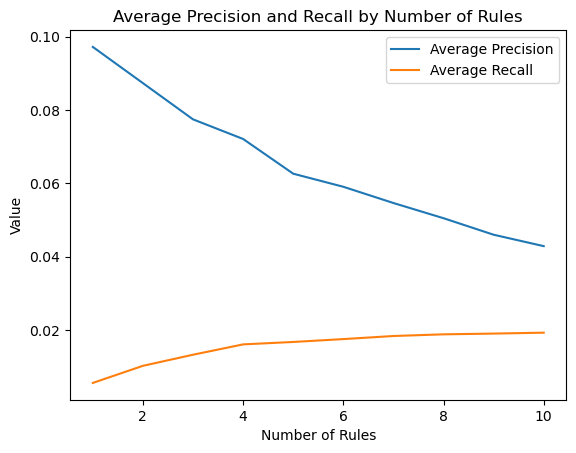

In [19]:
# Compute the average precision and average recall by varying the number of rules from 1 to 10 and plot the graphs

def evaluate_association_rules_varying_rules(user_rules, test_df, max_rules=10):
    total_users = len(test_df)
    average_precisions = []
    average_recalls = []
    for k in range(1, max_rules + 1):
        total_precision = 0
        total_recall = 0
        for user_id, rules in user_rules.items():
            test_movies = test_df[test_df['userId'] == user_id]['movieId'].values[0]
            predicted_movies = {movie for rule in rules[:k] for movie in rule[1]}
            true_positives = len(test_movies.intersection(predicted_movies))
            precision = true_positives / k
            recall = true_positives / len(test_movies)
            total_precision += precision
            total_recall += recall
        average_precisions.append(total_precision / total_users)
        average_recalls.append(total_recall / total_users)
    return average_precisions, average_recalls

average_precisions, average_recalls = evaluate_association_rules_varying_rules(user_rules, test_df)

import matplotlib.pyplot as plt

plt.plot(range(1, 11), average_precisions, label='Average Precision')
plt.plot(range(1, 11), average_recalls, label='Average Recall')
plt.xlabel('Number of Rules')
plt.ylabel('Value')
plt.title('Average Precision and Recall by Number of Rules')
plt.legend()
plt.show()


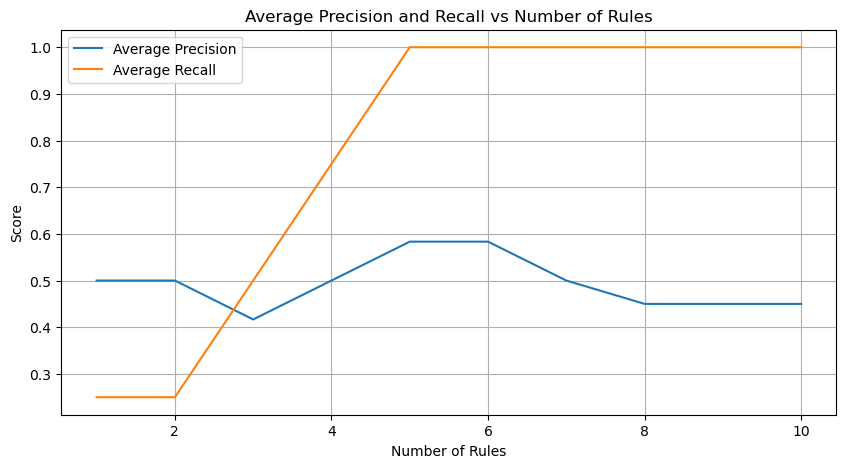

In [20]:
import matplotlib.pyplot as plt
from collections import defaultdict

def generate_rules_for_movies(frequent_itemsets, transactions, min_conf):
    rules = []
    
    for itemset in frequent_itemsets:
        if len(itemset) > 1:
            for item in itemset:
                antecedent = frozenset([item])  # X is a single movie
                consequent = itemset - antecedent
                if consequent:
                    support_itemset = calculate_support(itemset, transactions)
                    support_antecedent = calculate_support(antecedent, transactions)
                    
                    confidence = support_itemset / support_antecedent
                    
                    if confidence >= min_conf:
                        rule = (antecedent, consequent, confidence, support_itemset)
                        rules.append(rule)
    
    return rules

def calculate_support(itemset, transactions):
    count = sum(1 for transaction in transactions if itemset.issubset(transaction))
    return count / len(transactions)

def get_rules_for_user(user_movies, rules):
    user_rules = []
    for rule in rules:
        antecedent, consequent, confidence, support = rule
        if antecedent.issubset(user_movies):
            user_rules.append(rule)
    return sorted(user_rules, key=lambda x: x[2], reverse=True)  # Sort by confidence

def evaluate_recommendations(test_set, rules, n):
    total_precision = 0
    total_recall = 0
    
    for user, actual_movies in test_set.items():
        user_rules = get_rules_for_user(user, rules)[:n]
        recommended_movies = set().union(*[rule[1] for rule in user_rules])
        
        true_positives = len(recommended_movies.intersection(actual_movies))
        precision = true_positives / len(recommended_movies) if recommended_movies else 0
        recall = true_positives / len(actual_movies) if actual_movies else 0
        
        total_precision += precision
        total_recall += recall
    
    avg_precision = total_precision / len(test_set)
    avg_recall = total_recall / len(test_set)
    
    return avg_precision, avg_recall

def main():
    # Sample data (replace with your actual data)
    training_set = [
        {'movie1', 'movie2', 'movie3'},
        {'movie1', 'movie3', 'movie4'},
        {'movie2', 'movie3', 'movie5'},
        # ... more training data
    ]
    
    test_set = {
        frozenset(['movie1', 'movie2']): {'movie3', 'movie4'},
        frozenset(['movie2', 'movie3']): {'movie1', 'movie5'},
        # ... more test data
    }
    
    min_support = 0.1
    min_confidence = 0.5
    
    frequent_itemsets = apriori(training_set, min_support)  # Assume this function exists
    rules = generate_rules_for_movies(frequent_itemsets, training_set, min_confidence)
    
    precisions = []
    recalls = []
    
    for n in range(1, 11):
        precision, recall = evaluate_recommendations(test_set, rules, n)
        precisions.append(precision)
        recalls.append(recall)
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, 11), precisions, label='Average Precision')
    plt.plot(range(1, 11), recalls, label='Average Recall')
    plt.xlabel('Number of Rules')
    plt.ylabel('Score')
    plt.title('Average Precision and Recall vs Number of Rules')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
# Take a sample example of users and their movie ratings from the test set and display precision and recall graphs

def evaluate_recommendations(test_set, rules, n):
    total_precision = 0
    total_recall = 0
    
    for user, actual_movies in test_set.items():
        user_rules = get_rules_for_user(user, rules)[:n]
        recommended_movies = set().union(*[rule[1] for rule in user_rules])
        
        true_positives = len(recommended_movies.intersection(actual_movies))
        precision = true_positives / len(recommended_movies) if recommended_movies else 0
        recall = true_positives / len(actual_movies) if actual_movies else 0
        
        total_precision += precision
        total_recall += recall
    
    avg_precision = total_precision / len(test_set)
    avg_recall = total_recall / len(test_set)
    
    return avg_precision, avg_recall

